## SHAP values analysis

## Imports

In [5]:
from pandas import DataFrame


from rdkit.Chem import MolFromSmiles
import random

from featureImportance.shapValues import ShapValues
import joblib
from Datasets.Datasets import NumpyDataset
import json
import numpy as np


import pandas as pd

from utils import utils

from loaders.Loaders import CSVLoader

import os
from compoundFeaturization.rdkitFingerprints import MorganFingerprint

from pathlib import Path
dir_path = Path().absolute()



from rdkit.ML.Descriptors import MoleculeDescriptors

### Sweeteners preparation

In [6]:
carbohydrates = [
              ["beta-D-Xylopyranose", "C1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O", 1],
              ["beta-D-Fructopyranose", "C1[C@H]([C@H]([C@@H]([C@](O1)(CO)O)O)O)O", 1],
              ["beta-D-Glucopyranose", "C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O", 1],
              ["alpha-D-Glucopyranose", "C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O", 1],
              ["alpha-D-Galactose", "C([C@@H]1[C@@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O", 1],
              ["Maltitol", "C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@H]([C@@H](CO)O)[C@@H]([C@H](CO)O)O)O)O)O)O", 1], 
              ["Lactitol", "C([C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O[C@H]([C@@H](CO)O)[C@@H]([C@H](CO)O)O)O)O)O)O", 1] ,
              ["cellobitol", "C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O[C@H]([C@@H](CO)O)[C@@H]([C@H](CO)O)O)O)O)O)O", 1],
              ["cyclamate", "C1CCC(CC1)NS(=O)(=O)O", 1],
              ["5-Nitro-2-propoxyaniline", "CCCOC1=C(C=C(C=C1)[N+](=O)[O-])N", 1],
              ["6-chloro-D-tryptophan","CCCOC1=C(C=C(C=C1)[N+](=O)[O-])N",1],
              ["alitame", "C[C@H](C(=O)NC1C(SC1(C)C)(C)C)NC(=O)[C@H](CC(=O)O)N", 1],
              ["aspartame", "COC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)N", 1],
              ["neotame", "CC(C)(C)CCN[C@@H](CC(=O)O)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)OC", 1],
              ["saccharin", "C1=CC=C2C(=C1)C(=O)NS2(=O)=O", 1],
              ["dulcin", "CCOC1=CC=C(C=C1)NC(=O)N", 1],
]

carbohydrates = [i[1] for i in carbohydrates]

In [7]:


def get_mols_from_csv(input_file, structure_field):
    
    df = pd.read_csv(input_file)
    
    structures = df.loc[:,structure_field]
    
    return structures

In [8]:
def highlight_atoms_with_query(lst,smarts):
    to_highlight = []
    for mol in lst:
        mol = MolFromSmiles(mol)
        final_tuple = ()
        lst_idx = mol.GetSubstructMatches(smarts)
        for idx in lst_idx:
            final_tuple = final_tuple + idx


        to_highlight.append(final_tuple)
    return to_highlight


In [9]:
bitter_mols = get_mols_from_csv("../resources/data/clean_bitter_molecules.csv", "mols")

In [10]:
import shap

def run_shap_values_on_molecules(dataset, model, max_evals, columns_names):
    
    X = pd.DataFrame(dataset.X, columns=columns_names)

    model = model.model
    
    explainer = shap.explainers.Permutation(model.predict, X)
    shap_values = explainer(X, max_evals=max_evals)
    
    return shap_values
    
def get_features_to_keep(model_path, fs_config_file_path):
    
    if "all" in model_path:
        feature_selection = "none"
        if "2d" in model_path:
            features_to_keep = [i for i in range(208)]
        else:
            features_to_keep = [i for i in range(2048)]


    elif "KbestFS" in model_path:
        feature_selection = "KbestFS"
        f = open(fs_config_file_path,)

        data = json.load(f)

        features_to_keep = sorted(data["KbestFS"])

    elif "SelectFromModelFS" in model_path:
        feature_selection = "SelectFromModelFS"
        f = open(fs_config_file_path,)

        data = json.load(f)

        features_to_keep = sorted(data["SelectFromModelFS"])
        
    elif "Boruta" in model_path:
        feature_selection = "Boruta"
        f = open(fs_config_file_path,)

        data = json.load(f)

        features_to_keep = sorted(data["Boruta"])
        
    if "2d" in model_path:
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
        features_names = calc.GetDescriptorNames()
        features_names = [features_names[i] for i in features_to_keep]
    
    else:
        features_names = [f"bit {i}" for i in features_to_keep]
        
    return features_to_keep,features_names

In [12]:
def get_feature_and_ecfp4_draw(features_number, molecule):
    
    return utils.draw_morgan_bit_on_molecule(molecule, features_number, chiral=True)

        

In [13]:
def generate_conformers_and_calculate_distances(mol, it, atom_pairs):
    
    atom_pairs_result = {}
    for i,j in atom_pairs:
        results = np.empty(it)
        for k in range(it):
            m2, res, rmslist = get_conformers(mol, nConfGen=20,pruneRmsThreshVal=1)
            conf = m2.GetConformer()
            at1Coords = np.array(conf.GetAtomPosition(i))
            at2Coords = np.array(conf.GetAtomPosition(j))
            results[k] = np.linalg.norm(at2Coords - at1Coords)
            
        average = np.mean(results)
        std = np.std(results)
        atom_pairs_result[str(i) + "_" + str(j)] = (average,std)
    return atom_pairs_result

#### import test datasets

In [15]:


test_dataset = os.path.join("../resources/models", "test_dataset.csv")

loader = CSVLoader(test_dataset,
                       mols_field='mols',
                       labels_fields='y')

test_dataset = loader.create_dataset()

dataset_sweeteners = test_dataset.mols[test_dataset.y == 1]
dataset_non_sweeteners = test_dataset.mols[test_dataset.y == 0]

train_dataset = os.path.join("../resources/models", "train_dataset.csv")

loader = CSVLoader(train_dataset,
                       mols_field='mols',
                       labels_fields='y')

train_dataset = loader.create_dataset()



#### get bitter molecules

In [16]:
from rdkit.Chem import AllChem
from rdkit import DataStructs

bitter_molecules = []
for i, bitter_mol in enumerate(bitter_mols):
    bitter_mol = MolFromSmiles(bitter_mol)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(bitter_mol,2)
    for smiles2 in dataset_non_sweeteners:
        mol2 = MolFromSmiles(smiles2)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2,2)
        similarity = DataStructs.FingerprintSimilarity(fp1,fp2)
        if similarity == 1 and smiles2 not in bitter_molecules:
            bitter_molecules.append(mol2)
            break
            
    if len(bitter_molecules) == 40:
        break

In [18]:
bitter_molecules_sample = random.choices(bitter_mols, k=16)

In [20]:
sweeteners_dataset = NumpyDataset(mols = carbohydrates, ids=np.array([i for i in range(len(carbohydrates))]), y=np.array([1]*len(carbohydrates)))
bitter_dataset = NumpyDataset(mols = bitter_molecules_sample, ids=np.array([i for i in range(len(bitter_molecules_sample))]), y=np.array([0]*len(carbohydrates)))
dataset_to_test = sweeteners_dataset.merge([bitter_dataset])

In [21]:
from rdkit import Chem
from rdkit.Chem import AllChem

def get_conformers(mol, nConfGen=20,pruneRmsThreshVal=1):
    i=0


    m2=Chem.AddHs(mol)
    AllChem.EmbedMultipleConfs(m2,
                                    numConfs=nConfGen, 
                                    pruneRmsThresh=pruneRmsThreshVal,
                                    ignoreSmoothingFailures=True,
                                    numThreads=0)
    res =AllChem.MMFFOptimizeMoleculeConfs(m2, 
                                            maxIters=2000, 
                                            numThreads=0) 
    rmslist = []
    AllChem.AlignMolConformers(m2, RMSlist=rmslist)
    return m2, res, rmslist

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

## ECFP4 - SVM - SHAP analysis

In [49]:
dataset_to_test = os.path.join("../resources","SHAP_analysis/ecfp4_svm/set.csv")
df = pd.read_csv(dataset_to_test)
features = df.columns[3:]
loader = CSVLoader(dataset_to_test,
                   features_fields=list(features),
                       mols_field='mols',
                       labels_fields='y')

dataset_to_test = loader.create_dataset()

Mols_shape:  27
Features_shape:  (27, 2048)
Labels_shape:  (27,)


In [31]:
from standardizer.CustomStandardizer import CustomStandardizer

model_path = os.path.join("../resources/models", "ecfp4", "all_svm_model")
model = joblib.load(model_path)

standardisation_params = {
        'REMOVE_ISOTOPE': True,
        'NEUTRALISE_CHARGE': True,
        'REMOVE_STEREO': False,
        'KEEP_BIGGEST': True,
        'ADD_HYDROGEN': False,
        'KEKULIZE': True,
        'NEUTRALISE_CHARGE_LATE': True}

CustomStandardizer(params = standardisation_params).standardize(dataset_to_test)

MorganFingerprint(chiral=True).featurize(dataset_to_test)

fs_config_file_path = os.path.join(dir_path,"stratified_split/", "ecfp4", "feature_selection_config.json")

features_to_keep, feature_names = get_features_to_keep(model_path,fs_config_file_path)
dataset_to_test.select_features(features_to_keep)
print(len(features_to_keep))

shap_values_structures = run_shap_values_on_molecules(dataset_to_test, model, max_evals=10000, columns_names=feature_names)


Standardizing datapoint 0
Featurizing datapoint 0
2048


X has feature names, but SVC was fitted without feature names


KeyboardInterrupt: 

## Save results

In [711]:
np.savetxt("SHAP_analysis/ecfp4_svm/shap_values.csv", shap_values_structures.values, delimiter=",")
np.savetxt("SHAP_analysis/ecfp4_svm/base_values.csv", shap_values_structures.base_values, delimiter=",")
np.savetxt("SHAP_analysis/ecfp4_svm/data.csv", shap_values_structures.data, delimiter=",")
dataset_to_test.save_to_csv("SHAP_analysis/ecfp4_svm/set.csv")

In [59]:
from numpy import genfromtxt

explainer = shap.explainers.Permutation(None, None)
values = genfromtxt("../resources/SHAP_analysis/ecfp4_svm/shap_values.csv", delimiter=',')
base_values = genfromtxt("../resources/SHAP_analysis/ecfp4_svm/base_values.csv", delimiter=',')
data = genfromtxt("../resources/SHAP_analysis/ecfp4_svm/data.csv", delimiter=',')

In [60]:
shap_values_structures.values=values
shap_values_structures.base_values=base_values
shap_values_structures.data=data

In [61]:
shap.plots.beeswarm(shap_values_structures)

UnboundLocalError: local variable 'values' referenced before assignment

In [242]:
os.makedirs("SHAP_analysis/ecfp4_svm/", exist_ok=True)
dataset_to_test.save_to_csv("SHAP_analysis/ecfp4_svm/set.csv")

## Cyclamate

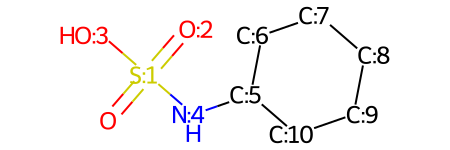

In [783]:
mol_index = 8
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

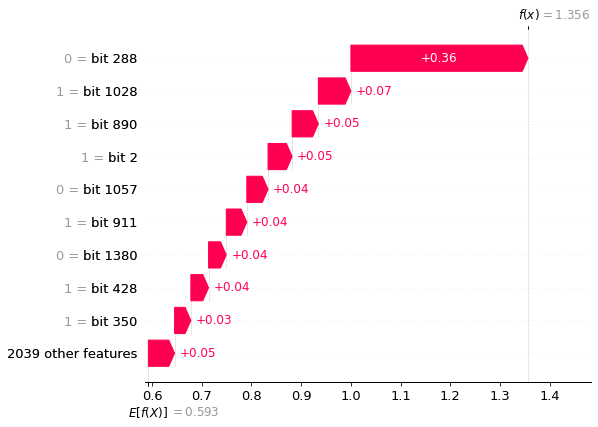

In [648]:
shap.plots.waterfall(shap_values_structures[mol_index])

In [685]:
bits = []
for i,bit in enumerate(dataset_to_test.X[mol_index]):
    if bit == 1:
        bits.append(i)
        
print(bits)

[2, 92, 350, 428, 455, 592, 650, 807, 890, 911, 926, 1019, 1028, 1152, 1325, 1461, 1476, 1630, 1634]


In [784]:
x = [2,890]

cumulative_shap = 0

for bit in x:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.10113960113960116

In [785]:
b = [807]

cumulative_shap = 0

for bit in b:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.025641025641025647

In [786]:
ah = [1152]

cumulative_shap = 0

for bit in ah:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.015669515669515677

In [810]:

get_feature_and_ecfp4_draw(1557, dataset_to_test.mols[mol_index])

Bits ON:  dict_keys([1, 38, 44, 80, 117, 283, 387, 389, 510, 558, 573, 650, 675, 786, 797, 807, 834, 852, 913, 1019, 1057, 1060, 1141, 1149, 1152, 1171, 1274, 1290, 1318, 1565, 1737, 1768, 1776, 1895, 1917, 1932])


ValueError: Bit is off! Select a on bit

Bit 890 with 2 hits!


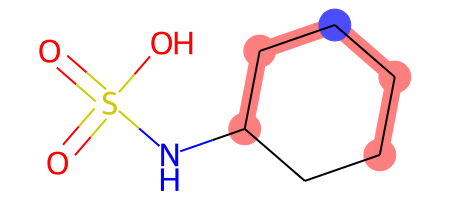

In [714]:
get_feature_and_ecfp4_draw(890, dataset_to_test.mols[mol_index])

Bit 890 with 2 hits!


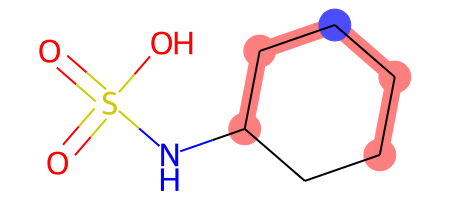

In [127]:
get_feature_and_ecfp4_draw(890, features_to_keep, dataset_to_test.mols[mol_index])

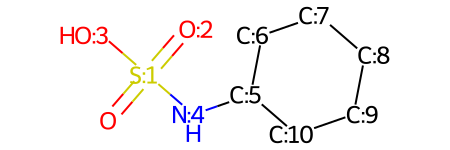

In [715]:
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

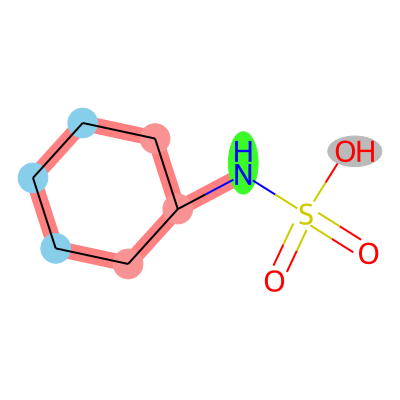

In [726]:
from matplotlib.colors import ColorConverter
colors = {}

red = [6,5,10]
center_x = [7,8,9]
center_ah = [4]
center_b = [3]

for bit in red:
    colors[bit] = ColorConverter().to_rgb('#f99393')
    
for bit in center_x:
    colors[bit] = ColorConverter().to_rgb('skyblue')
    
for bit in center_b:
    colors[bit] = ColorConverter().to_rgb('#bababa')

for bit in center_ah:
    colors[bit] = ColorConverter().to_rgb('#3cfa29')
    
mol = MolFromSmiles(dataset_to_test.mols[mol_index])
m2, res, rmslist = get_conformers(mol, nConfGen=20,pruneRmsThreshVal=1)
AllChem.Compute2DCoords(m2)
m2 = Chem.RemoveHs(m2)

Draw.MolsToGridImage([m2],highlightAtomLists=[colors.keys()],
                     highlightAtomColors=[colors], molsPerRow=1, subImgSize=(400,400))

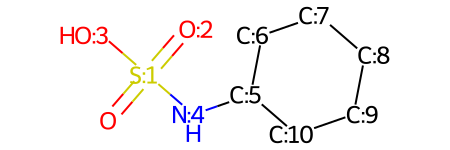

In [82]:
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

In [365]:
atom_pairs = [(7,5)]
atom_pairs_result = generate_conformers_and_calculate_distances(MolFromSmiles(dataset_to_test.mols[mol_index]), 50, atom_pairs)

In [366]:
atom_pairs_result

{'7_5': (2.5412135774238593, 0.012109059531491707)}

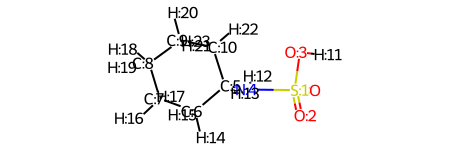

In [84]:
mol_with_atom_index(m2)

In [85]:
conf = m2.GetConformer()  
at1Coords = np.array(conf.GetAtomPosition(3))
at2Coords = np.array(conf.GetAtomPosition(4))
print(np.linalg.norm(at2Coords - at1Coords))

2.561381946664298


## 1-n-propoxy-2-am ino-4-nitrobenzene (4000x)

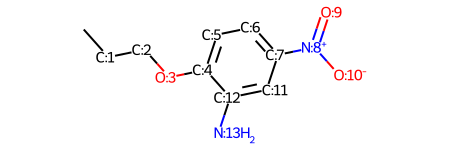

In [787]:
mol_index = 9
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

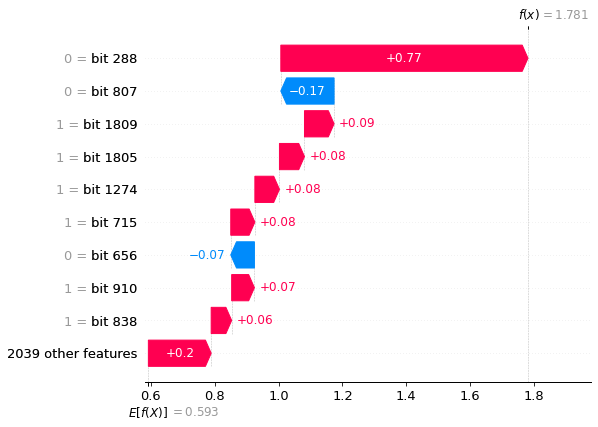

In [671]:
shap.plots.waterfall(shap_values_structures[mol_index])

In [790]:
b = [715]

cumulative_shap = 0

for bit in b:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.0754985754985755

In [791]:
ah = [1750]

cumulative_shap = 0

for bit in ah:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.0071225071225071174

In [793]:
shap_values_structures.values[mol_index][1809]

0.09259259259259257

Bit 715 with 1 hits!


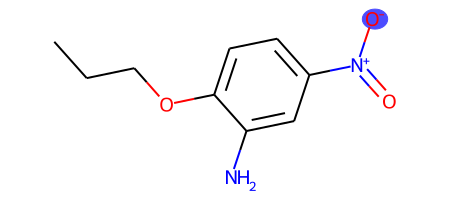

In [789]:
get_feature_and_ecfp4_draw(715, dataset_to_test.mols[mol_index])

In [644]:
shap_values_structures.values[mol_index][1750]

0.008547008547008548

In [569]:
def get_negative_positive_impact_active_bits(shap_values_structures,mol_index):
    negative_shap = 0
    for i, value in enumerate(shap_values_structures.values[mol_index]):
        if value < 0 and shap_values_structures.data[mol_index][i] == 1:
            negative_shap+=value
    return negative_shap


In [567]:
negative_shap = 0
for i,value in enumerate(shap_values_structures.values[mol_index]):
    if value > 0 and shap_values_structures.data[mol_index][i] == 1:
        negative_shap+=value
negative_shap

0.8974358974358972

.
generating conformers for molecule  0
not_converged  /  energy
[(0, 52.32079156360164)]
rms list
[]


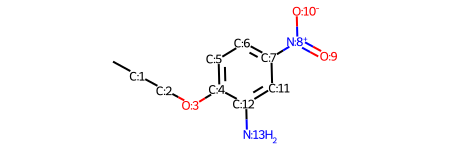

In [290]:
mol = MolFromSmiles(dataset_to_test.mols[mol_index])
m2, res, rmslist = get_conformers(MolFromSmiles(dataset_to_test.mols[mol_index]), nConfGen=20,pruneRmsThreshVal=1)
AllChem.Compute2DCoords(m2)
m2 = Chem.RemoveHs(m2)
mol_with_atom_index(m2)

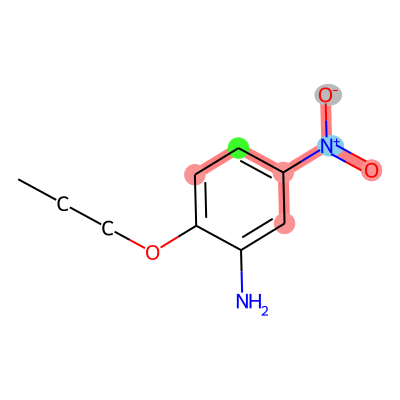

In [747]:
from matplotlib.colors import ColorConverter
colors = {}

red = [7,11,9, 5]
center_whole = [8]
center_ah = [6]
center_b = [10]

for bit in red:
    colors[bit] = ColorConverter().to_rgb('#f99393')
    
for bit in center_whole:
    colors[bit] = ColorConverter().to_rgb('skyblue')
    
for bit in center_b:
    colors[bit] = ColorConverter().to_rgb('#bababa')

for bit in center_ah:
    colors[bit] = ColorConverter().to_rgb('#3cfa29')
    
mol = MolFromSmiles(dataset_to_test.mols[mol_index])
m2, res, rmslist = get_conformers(MolFromSmiles(dataset_to_test.mols[mol_index]), nConfGen=20,pruneRmsThreshVal=1)
AllChem.Compute2DCoords(m2)
m2 = Chem.RemoveHs(m2)

Draw.MolsToGridImage([m2],highlightAtomLists=[colors.keys()],
                     highlightAtomColors=[colors], molsPerRow=1, subImgSize=(400,400))

In [281]:
colors

{9: (1.0, 0.0, 0.0),
 10: (0.5294117647058824, 0.807843137254902, 0.9215686274509803),
 8: (0.5294117647058824, 0.807843137254902, 0.9215686274509803),
 7: (1.0, 0.0, 0.0),
 6: (1.0, 0.0, 0.0),
 11: (0.5294117647058824, 0.807843137254902, 0.9215686274509803)}

Bit 1750 with 2 hits!


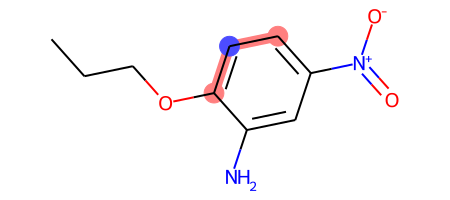

In [734]:
get_feature_and_ecfp4_draw(1750, dataset_to_test.mols[mol_index])

Bit 838 with 1 hits!


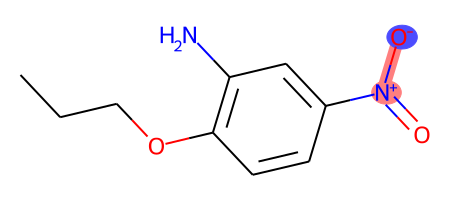

In [171]:
get_feature_and_ecfp4_draw(838, features_to_keep, dataset_to_test.mols[mol_index])

In [381]:
atom_pairs = [(10,6)]
atom_pairs_result = generate_conformers_and_calculate_distances(MolFromSmiles(dataset_to_test.mols[mol_index]), 50, atom_pairs)

In [382]:
atom_pairs_result

{'10_6': (3.2123752321120658, 0.4188116701400263)}

In [303]:
m2, res, rmslist = get_conformers(MolFromSmiles(dataset_to_test.mols[mol_index]), nConfGen=20,pruneRmsThreshVal=1)

.
generating conformers for molecule  0
not_converged  /  energy
[(0, 52.6488441020537)]
rms list
[]


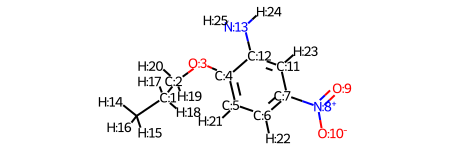

In [274]:
mol_with_atom_index(m2)

In [304]:
conf = m2.GetConformer()  
at1Coords = np.array(conf.GetAtomPosition(10))
at2Coords = np.array(conf.GetAtomPosition(6))
print(np.linalg.norm(at2Coords - at1Coords))

2.7397374868765487


## Carbohydrates

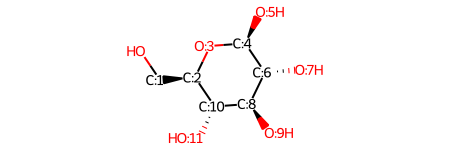

In [794]:
mol_index = 2
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

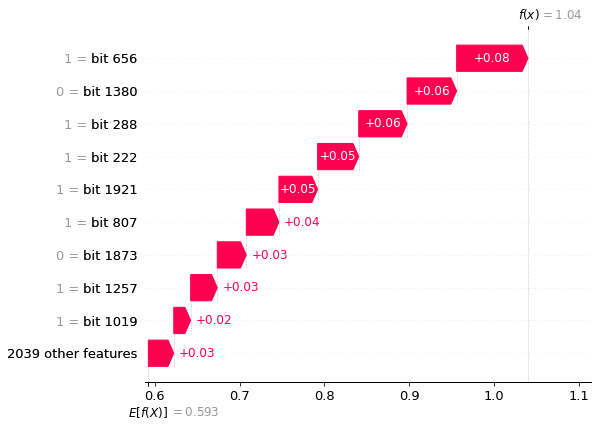

In [668]:
shap.plots.waterfall(shap_values_structures[mol_index])

Bit 1257 with 4 hits!


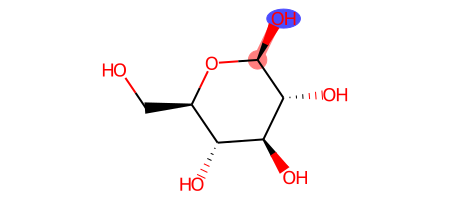

In [800]:
get_feature_and_ecfp4_draw(1257, dataset_to_test.mols[mol_index])

In [592]:
shap_values_structures.values[mol_index][1257]

0.0626780626780627

In [799]:
bits = [807,1257]

cumulative_shap = 0

for bit in bits:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.06980056980056981

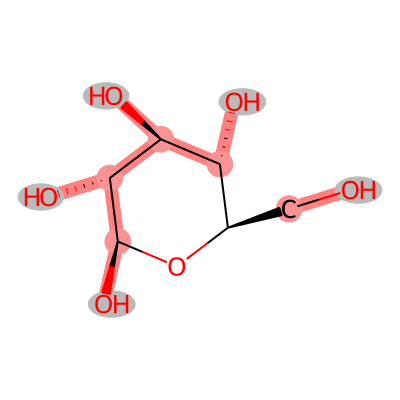

In [755]:
from rdkit.Chem import Draw

colors = {}

red = [4,6,8,10,1]
center_whole = [7,11,9,5,0]

for bit in center_whole:
    colors[bit] = ColorConverter().to_rgb('#bababa')
    
for bit in red:
    colors[bit] = ColorConverter().to_rgb('#f99393')

    
mol = MolFromSmiles(dataset_to_test.mols[mol_index])
m2, res, rmslist = get_conformers(mol, nConfGen=20,pruneRmsThreshVal=1)
AllChem.Compute2DCoords(m2)
m2 = Chem.RemoveHs(m2)

Draw.MolsToGridImage([m2],highlightAtomLists=[colors.keys()],
                     highlightAtomColors=[colors], molsPerRow=1, subImgSize=(400,400))


Bit 807 with 5 hits!


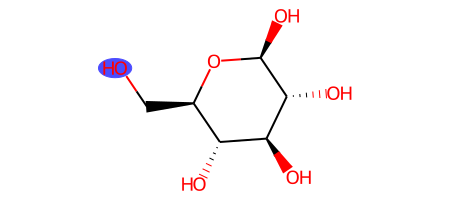

In [108]:
get_feature_and_ecfp4_draw(807, features_to_keep, dataset_to_test.mols[mol_index])

In [361]:
atom_pairs = [(7,5), (11,9), (7,9)]
atom_pairs_result = generate_conformers_and_calculate_distances(MolFromSmiles(dataset_to_test.mols[mol_index]), 50, atom_pairs)

In [362]:
atom_pairs_result

{'7_5': (3.128582412325014, 0.34857651428702274),
 '11_9': (2.922438224339916, 0.2411208295769962),
 '7_9': (3.0123417057772084, 0.24793210808674243)}

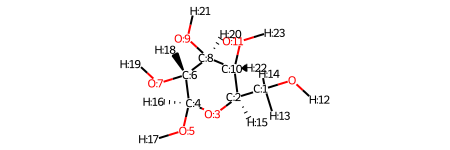

In [160]:
m_2d = copy(m2)
AllChem.Compute2DCoords(m_2d)
mol_with_atom_index(m_2d)

In [270]:
conf = m2.GetConformer()  
at1Coords = np.array(conf.GetAtomPosition(7))
at2Coords = np.array(conf.GetAtomPosition(5))
print(np.linalg.norm(at2Coords - at1Coords))
at1Coords = np.array(conf.GetAtomPosition(11))
at2Coords = np.array(conf.GetAtomPosition(9))
print(np.linalg.norm(at2Coords - at1Coords))
at1Coords = np.array(conf.GetAtomPosition(7))
at2Coords = np.array(conf.GetAtomPosition(9))
print(np.linalg.norm(at2Coords - at1Coords))

3.7103013260082927
3.0660716014162226
3.596023368408794


RuntimeError: Range Error
	atomId
	Violation occurred on line 62 in file Code/GraphMol/Conformer.cpp
	Failed Expression: 24 < 24
	RDKIT: 2021.09.4
	BOOST: 1_74


## Alitame

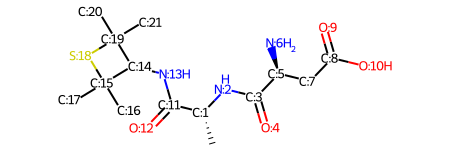

In [802]:
mol_index = 11
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

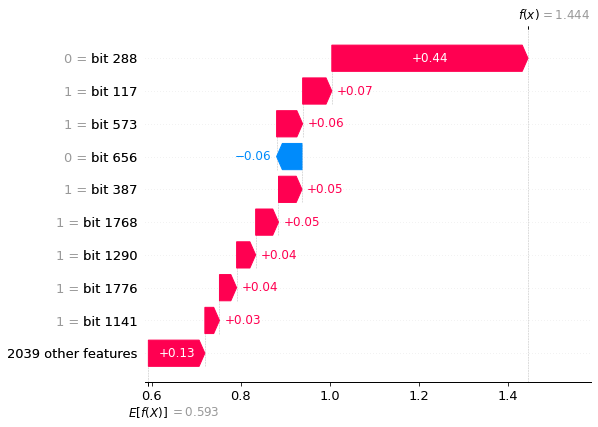

In [650]:
shap.plots.waterfall(shap_values_structures[mol_index])

In [655]:
bits = [558, 1565, 786, 117, 786, 1932, 387, 650, 1171]

cumulative_shap = 0

for bit in bits:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.22792022792022795

In [657]:
ah = [117, 786, 387, 1171]
cumulative_shap = 0

for bit in ah:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.1566951566951567

In [660]:
b = [650]
cumulative_shap = 0

for bit in b:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

-0.0056980056980057

In [661]:
x = [1932]
cumulative_shap = 0

for bit in x:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.017094017094017096

In [803]:
dihedral = [1565]
cumulative_shap = 0

for bit in dihedral:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
cumulative_shap

0.01566951566951567

## Theory of dihedral angles

Bit 1565 with 1 hits!


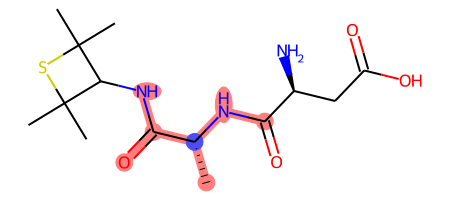

In [207]:
get_feature_and_ecfp4_draw(1565, dataset_to_test.mols[mol_index])

Bit 558 with 1 hits!


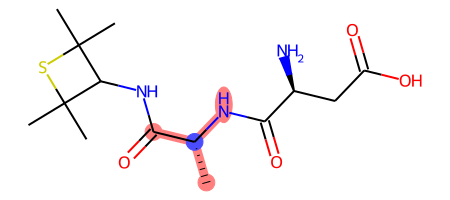

In [757]:
get_feature_and_ecfp4_draw(558, dataset_to_test.mols[mol_index])

Bit 807 with 4 hits!


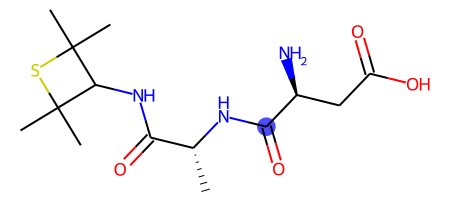

In [426]:
get_feature_and_ecfp4_draw(807, dataset_to_test.mols[mol_index])

## AH-B-X

In [436]:
get_feature_and_ecfp4_draw(0, dataset_to_test.mols[mol_index])

Bits ON:  dict_keys([1, 38, 44, 80, 117, 283, 387, 389, 510, 558, 573, 650, 675, 786, 797, 807, 834, 852, 913, 1019, 1057, 1060, 1141, 1149, 1152, 1171, 1274, 1290, 1318, 1565, 1737, 1768, 1776, 1895, 1917, 1932])


ValueError: Bit is off! Select a on bit

Bit 1932 with 1 hits!


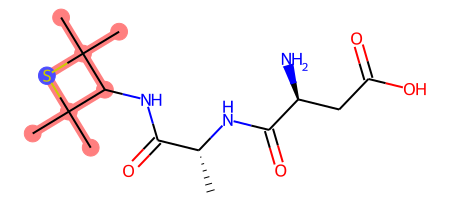

In [481]:
get_feature_and_ecfp4_draw(558, dataset_to_test.mols[mol_index])

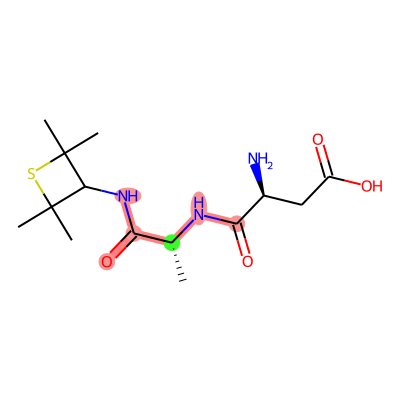

In [763]:
colors = {}

red = [2,3,11,12,13]
center_whole = [8]
center_dihedral = [1]

for bit in red:
    colors[bit] = ColorConverter().to_rgb('#f99393')
    
for bit in center_dihedral:
    colors[bit] = ColorConverter().to_rgb('#3cfa29')
    
mol = MolFromSmiles(dataset_to_test.mols[mol_index])

Draw.MolsToGridImage([mol],highlightAtomLists=[colors.keys()],
                     highlightAtomColors=[colors], molsPerRow=1, subImgSize=(400,400))

In [221]:
m2, res, rmslist = get_conformers(MolFromSmiles(dataset_to_test.mols[mol_index]), nConfGen=20,pruneRmsThreshVal=1)

.
generating conformers for molecule  0
not_converged  /  energy
[(0, 35.795620215126256), (0, 35.18455393899322), (0, 26.77604334123141), (0, 30.22583758596249), (0, 30.548203362276134)]
rms list
[2.19631486064472, 2.568573497262756, 2.3219034319011747, 1.7582486767883299]


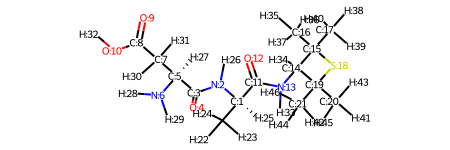

In [223]:
from copy import copy
m_2d = copy(m2)
AllChem.Compute2DCoords(m_2d)
mol_with_atom_index(m_2d)

In [165]:
for i in range(len(res)):
    conf = m2.GetConformer(i)  
    at1Coords = np.array(conf.GetAtomPosition(10))
    at2Coords = np.array(conf.GetAtomPosition(6))
    print(np.linalg.norm(at2Coords - at1Coords))


4.357524838040006
4.77492065304556
4.229061256515327
4.268902502109762
